In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage.io import imread,imsave
from xpeem_utils import *
import matplotlib as mpl
from numba import jit, njit, prange
# plt.rcParams['text.usetex'] = True
# plt.rcParams.update({'mathtext.default':  'regular' })
mpl.rcParams['figure.dpi'] = 300

In [3]:
@jit(parallel=True)
def mean_numba_3d(a):
    """implement a 3d mean for numba that doesn't use the axis instructions"""
    res = []
    for i in prange(a.shape[0]):
        res.append(a[i, :,:].mean())

    return np.array(res)

def calc_ra(image,normalize=True):
    """calculate the average roughness value value for image array with shape [frame, x, y].  Any parts of the image 
    that are masked should be replaced with NaN, not zero"""
    ra_values = np.zeros(len(image))
    for i in range(len(image)):
        averages = np.ones((image.shape[1:]))*np.nanmean(image[i,:,:])
        ra_values[i] = np.nanmean(np.abs(image[i]-averages))
    
    if normalize:
        return ra_values/np.nanmean(image,axis=(1,2))
    return ra_values

# @njit
def calc_ra_2d(image,normalize=True):
    """calculate the average roughness value value for image array with shape [x, y].  Any parts of the image 
    that are masked should be replaced with NaN, not zero"""

    averages = np.ones(image.shape)*np.mean(image)
    ra_value = np.mean(np.abs(image-averages))

    if normalize:
        return ra_value/np.mean(image)
    return ra_value

# @njit
def calc_ra_no_nan(image,normalize):
    """calculate the average roughness value value for image array with shape [frame, x, y].  Any parts of the image 
    that are masked should be replaced with NaN, not zero"""
    ra_values = np.zeros(len(image))
    for i in range(len(image)):
        averages = np.ones((image.shape[1:]))*np.mean(image[i,:,:])
        ra_values[i] = np.mean(np.abs(image[i]-averages))

    if normalize:
        return ra_values/np.mean(image)
    return ra_values

#@njit(parallel=True)
def batch_level_Ra(image: np.array, tileshape: tuple, imageshape: tuple, progressupdate=True):
    """efficient numba implementation of a function that takes a 3d image as a np array, tiles it, levels it, 
    and segments it """
    segmented_timeseries = np.zeros(image.shape)
    ra_val_list = np.zeros(len(image))

    for frameid in range(image.shape[0]):
        
        frame = image[frameid,:,:]
        tiles = tile_image(frame, tileshape)
        segmented = np.zeros(tiles.shape)
        ra_vals_frame = np.zeros((tiles.shape[0],tiles.shape[1]))


        for i in prange(tiles.shape[0]):
            for j in prange(tiles.shape[1]):
                tile = tiles[i,j,:,:]
                leveltile = plane_level_njit(tile)
                ra_val = calc_ra_2d(leveltile,False)
                # print(ra_val)

                #segmented[i,j,:,:].fill(ra_val)
                ra_vals_frame[i,j] = ra_val
                #print(segmented)
                break
        # print(segmented.shape,imageshape)
        # print(segmented_timeseries.shape)
        print(np.nanmean(ra_vals_frame))
        ra_val_list[frameid] = np.nanmean(ra_vals_frame)/np.mean(image[frameid,:,:])

        # reformed = reform_image(segmented, imageshape)
        # segmented_timeseries[frameid,:,:] = reformed.astype(np.uint8)
        if frameid%50 ==0 and progressupdate:
            print("frame: "+str(frameid))

    return ra_val_list

def zeros_to_nan(arr:ArrayLike):
    return np.where(arr == 0, np.nan,arr)

In [4]:
"""Try out using the roughness for the Ni22Cr data"""

# ni22cr_ox2 = imread('/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Movies/45L_3-CrXAS-movie@577-5eV.tif')
# ni22cr_ox3 = imread('/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Movies/45L_2-CrXAS-movie@577-5eV.tif')
# print(ni22cr_ox2.shape)
# ni22cr_ox2_ra = batch_level_Ra(ni22cr_ox2,(512,512),(1024,1024))
# ni22cr_ox3_ra = batch_level_Ra(ni22cr_ox3,(512,512),(1024,1024))


'Try out using the roughness for the Ni22Cr data'

In [5]:
# ni22cr_ox2_ra = calc_ra(ni22cr_ox2,True)
# ni22cr_ox3_ra = calc_ra(ni22cr_ox3,True)

In [6]:
# plt.plot(np.linspace(29,48,len(ni22cr_ox2_ra)),ni22cr_ox2_ra)
# plt.plot(np.linspace(48,65,len(ni22cr_ox3_ra)),ni22cr_ox3_ra)
# print(ni22cr_ox3_ra[170])

In [7]:
leftgrain = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Brookhaven experiment 1/bottom_left_grain.tif")
rightgrain = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Brookhaven experiment 1/right_grain.tif")
centergrain = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Brookhaven experiment 1/centergrain.tif")
exclude = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Brookhaven experiment 1/gb_and_initial_particles.tif")


live_ox_1 = imread("/Users/apple/Sync/Research/Mo XPEEM/20230717_Ni22Cr6Mo/After Second Sputter/Live Oxidation/XAS_30um_2CA_1AN_578eV_Cr2p_oxidation1/XAS_30um_2CA_1AN_578eV_Cr2p_oxidation1.tif")
live_ox_2 = imread("/Users/apple/Sync/Research/Mo XPEEM/20230717_Ni22Cr6Mo/After Second Sputter/Live Oxidation/XAS_30um_2CA_1AN_578eV_Cr2p_oxidation2/XAS_30um_2CA_1AN_578eV_Cr2p_oxidation2.tif")
print(len(live_ox_1),len(live_ox_2))

live_ox = mask_subtract_arr(np.concatenate((live_ox_1,live_ox_2),axis=0),exclude)
print(live_ox.shape[1:])

33 52
(1024, 1024)


In [8]:
leftgrain_ox = mask_subtract_arr(live_ox,leftgrain)
rightgrain_ox = mask_subtract_arr(live_ox,rightgrain)
centergrain_ox = mask_subtract_arr(live_ox,centergrain)


leftgrain_ox = np.where(leftgrain == 0, np.nan,leftgrain_ox)
rightgrain_ox = np.where(rightgrain_ox == 0, np.nan, rightgrain_ox)
centergrain_ox = np.where(centergrain_ox == 0, np.nan, centergrain_ox)

mo_ox_langmuir = np.linspace(0,60, len(live_ox))


Text(0, 0.5, 'Photoelectron yield (arb. u.)')

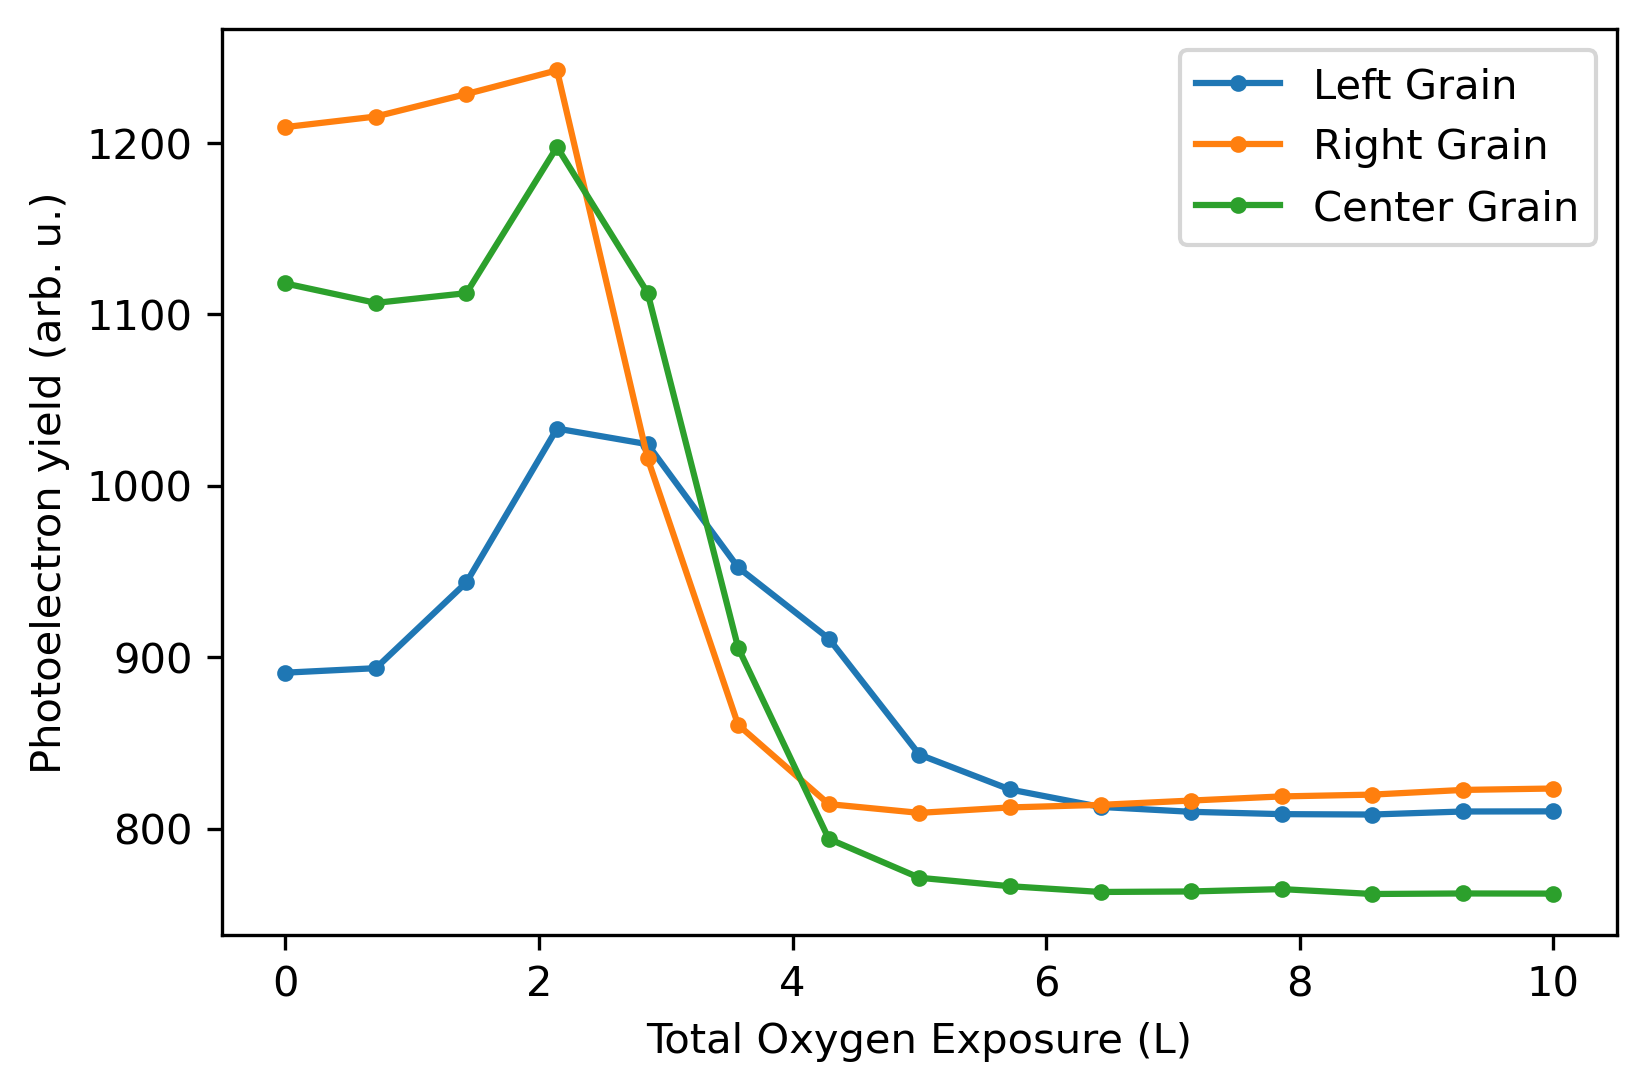

In [9]:
plt.plot(mo_ox_langmuir[0:15], np.nanmean(leftgrain_ox,axis=(1,2))[0:15], marker = '.')
plt.plot(mo_ox_langmuir[0:15], np.nanmean(rightgrain_ox,axis=(1,2))[0:15],marker = '.')
plt.plot(mo_ox_langmuir[0:15], np.nanmean(centergrain_ox,axis=(1,2))[0:15],marker = '.')
plt.legend(["Left Grain",'Right Grain','Center Grain'])
# plt.title("Ni22Cr6Mo Oxygen Adsorption")
plt.xlabel("Total Oxygen Exposure (L)")
plt.ylabel("Photoelectron yield (arb. u.)")

In [10]:
leftgrain_Ra = calc_ra(leftgrain_ox,normalize=True)
rightgrain_Ra = calc_ra(rightgrain_ox,normalize=True)
centergrain_Ra = calc_ra(centergrain_ox,normalize=True)

(0.0, 0.2)

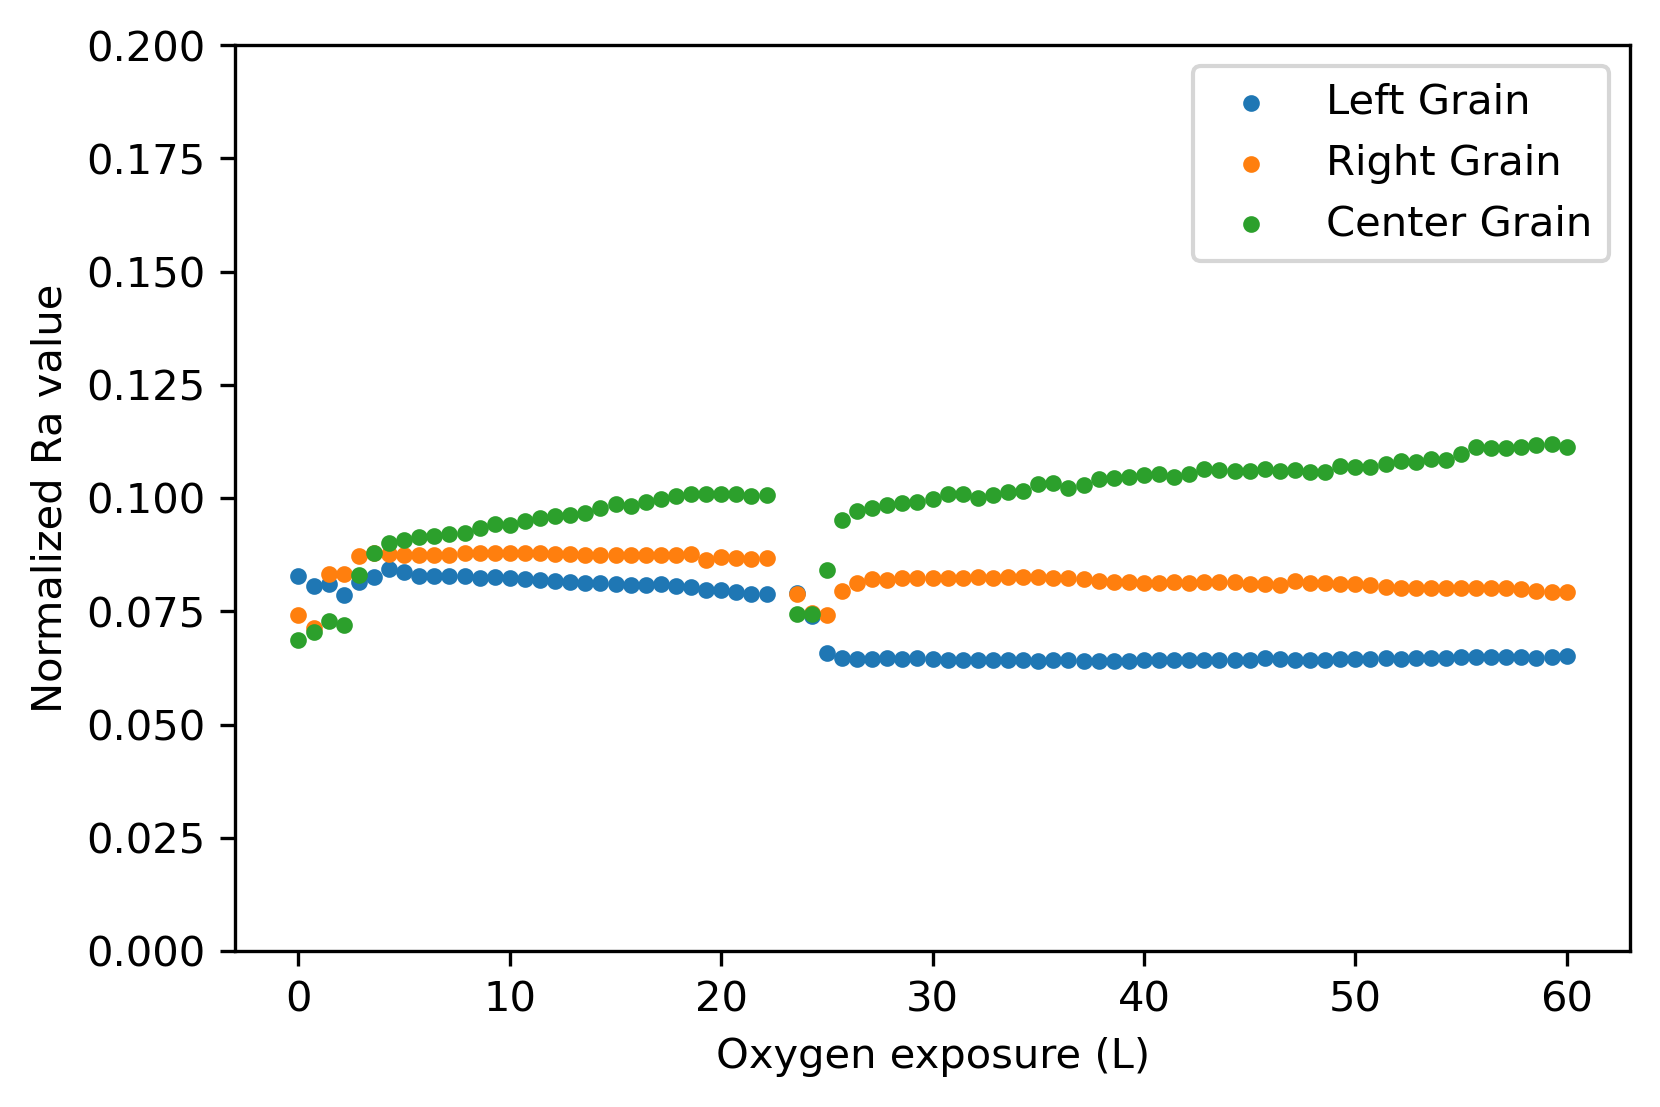

In [11]:


plt.scatter(mo_ox_langmuir, leftgrain_Ra, marker='.')
plt.scatter(mo_ox_langmuir, rightgrain_Ra, marker='.')
plt.scatter(mo_ox_langmuir, centergrain_Ra, marker='.')
plt.legend(["Left Grain",'Right Grain','Center Grain'])
# plt.title("Ni22Cr6Mo")
plt.xlabel("Oxygen exposure (L)")
plt.ylabel("Normalized Ra value")
plt.ylim([0,.2])

In [12]:
ni5_1 = imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Live Oxidation XAS/XAS_30um_2CA_1AN_854eV_Ni2p_oxidation1_region2/XAS_30um_2CA_1AN_854eV_Ni2p_oxidation1_region2.tif")
ni5_2 = imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Live Oxidation XAS/XAS_30um_2CA_1AN_578eV_Cr2p_oxidation2_region2/Oxidation 2 region 2.tif")
ni5_ox = np.concatenate((ni5_1,ni5_2),axis=0)
ni5_langmuir_10_60 = np.linspace(10, 60, len(ni5_2))
ni5_left_mask = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Ni5 Masks/Ni5 left grain.tif")
ni5_right_mask = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Ni5 Masks/Ni5 right grain.tif")
ni5_top_mask = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Ni5 Masks/Ni5 top grain.tif")


Text(0, 0.5, 'Normzlized Ra value')

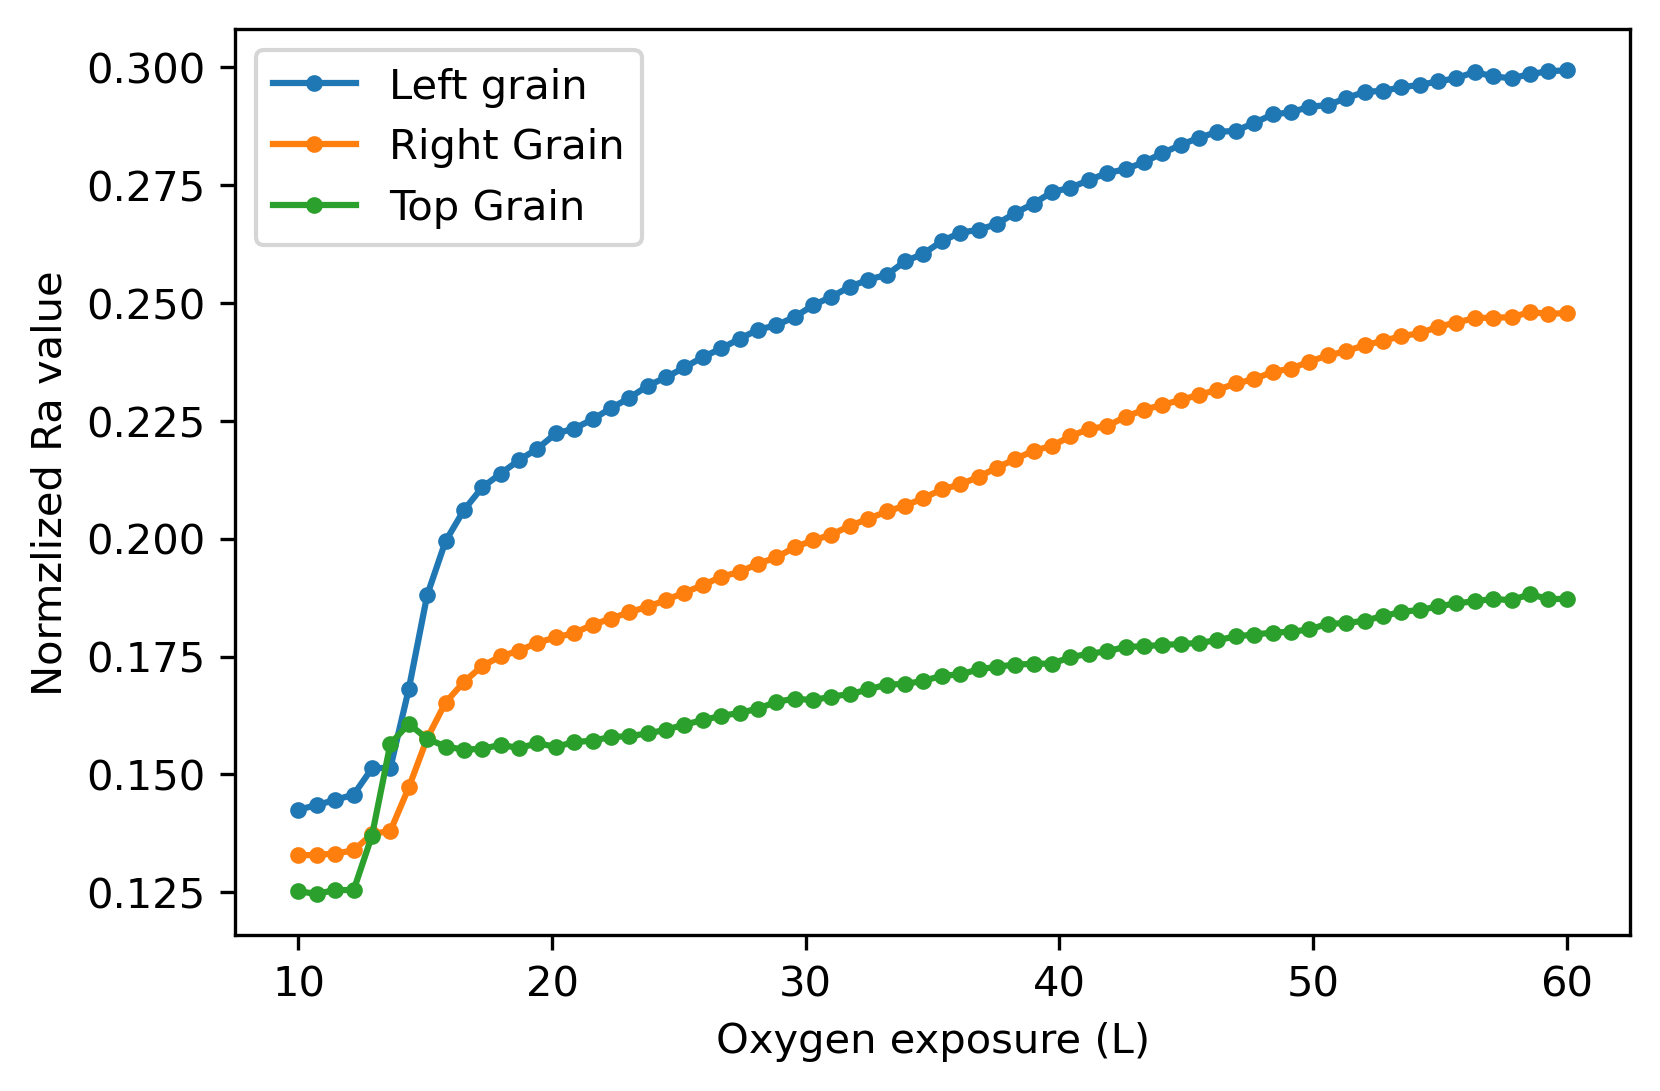

In [13]:
# ni5_ox_left = mask_subtract_arr(ni5_2,ni5_left_mask)
# ni5_ox_right = mask_subtract_arr(ni5_2, ni5_right_mask)

plt.plot(ni5_langmuir_10_60, calc_ra(mask_subtract_arr(ni5_2,ni5_left_mask),normalize=True),marker='.')
plt.plot(ni5_langmuir_10_60, calc_ra(mask_subtract_arr(ni5_2,ni5_right_mask),normalize=True),marker='.')
plt.plot(ni5_langmuir_10_60, calc_ra(mask_subtract_arr(ni5_2,ni5_top_mask),normalize=True),marker='.')
# plt.title("Ni5Cr")
plt.legend(["Left grain", "Right Grain", "Top Grain"])
plt.xlabel("Oxygen exposure (L)")
plt.ylabel("Normzlized Ra value")

In [14]:
replication = imread("/Users/apple/Sync/Research/Mo XPEEM/20240612_Ni22Cr6Mo/Oxidation 2/20240614_XPEEM_2CA_2AN_50um_576.5eV_Cr2p_live_oxidation_450C/0-60L aligned.tif")

left_mask = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Brookhaven experiment 2/left_mask.tif")
right_mask = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Brookhaven experiment 2/right_mask.tif")
rep_exclude_mask = imread("/Users/apple/Sync/Research/Mo XPEEM/Masks/Brookhaven experiment 2/replication mask.tif")

replication = mask_subtract_arr(replication, rep_exclude_mask)


In [15]:
rep_ox_to_L = np.arange(0,60.1,.44)
print(len(rep_ox_to_L))

137


In [16]:
rep_ox_left = zeros_to_nan(mask_subtract_arr(replication, left_mask))
rep_ox_right = zeros_to_nan(mask_subtract_arr(replication, right_mask))

Text(0.5, 0, 'Oxygen exposure (L)')

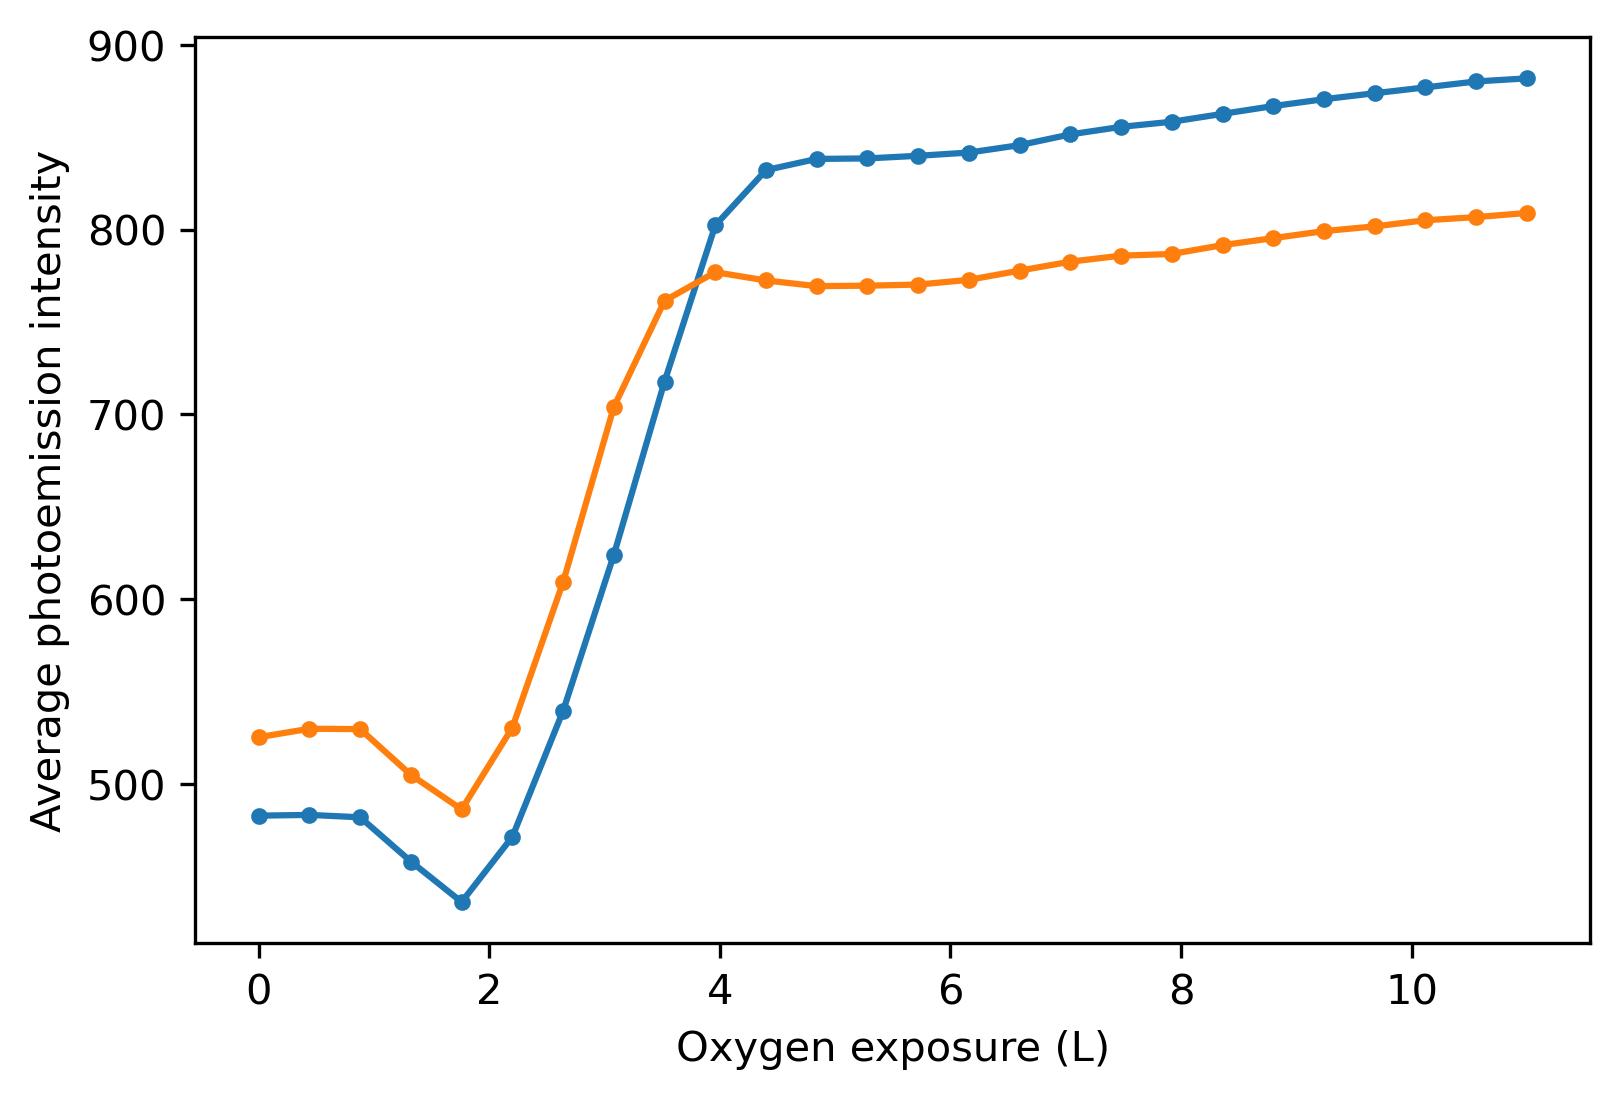

In [17]:
plt.plot(rep_ox_to_L[:26],np.nanmean(rep_ox_left,axis=(1,2))[6:32],marker='.')
plt.plot(rep_ox_to_L[:26],np.nanmean(rep_ox_right,axis=(1,2))[6:32],marker='.')
plt.ylabel("Average photoemission intensity")
plt.xlabel("Oxygen exposure (L)")

In [18]:
print(rep_ox_left.shape)
rep_ra_left = calc_ra(rep_ox_left,normalize=True)
rep_ra_right = calc_ra(rep_ox_right,normalize=True)

(149, 1024, 1024)


The oxidation doesn't start at the exact beginning of image series, there's a few frames before the oxygen pressure reached the target.  I think this happens at about image 6, this is when there are sharp changes in the image 

Text(0.5, 0, 'Frame')

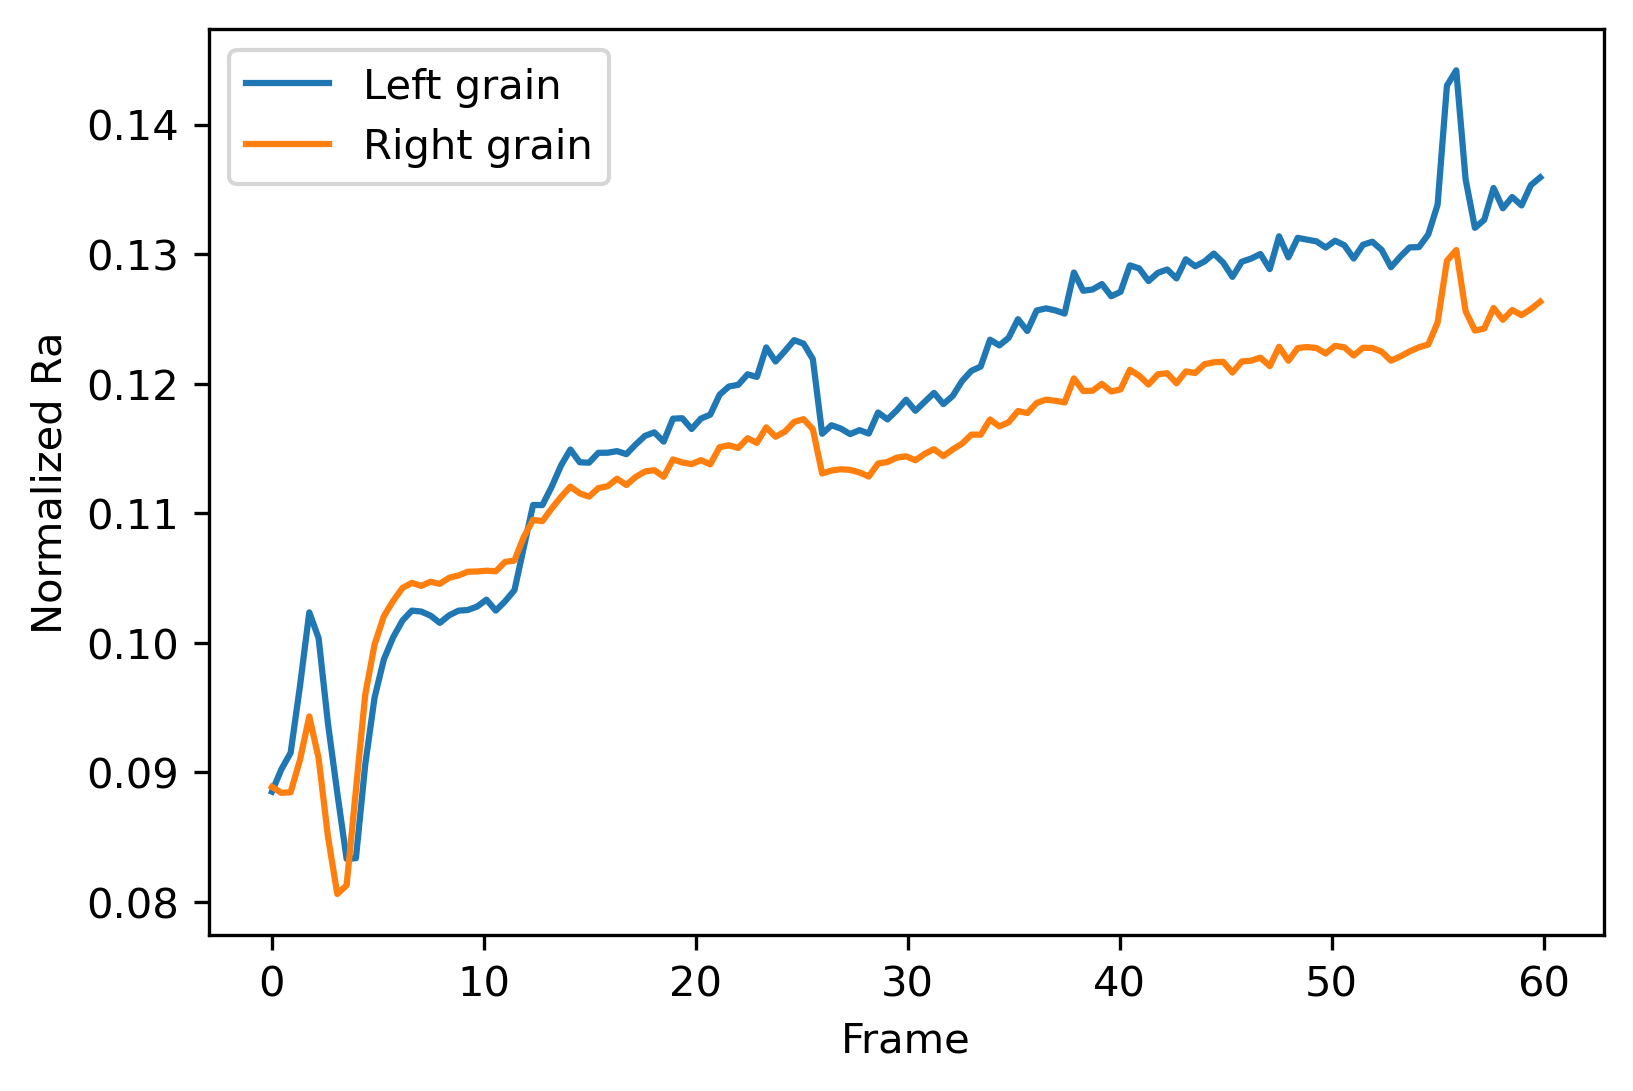

In [19]:
plt.plot(rep_ox_to_L, rep_ra_left[6:143])
plt.plot(rep_ox_to_L, rep_ra_right[6:143])
plt.legend(["Left grain", "Right grain"])
plt.ylabel("Normalized Ra")
plt.xlabel('Frame')

In [20]:
"""Look at the LEEM live oxidation"""

# leem_ox = imread("/Users/apple/Sync/Research/Mo XPEEM/20240612_Ni22Cr6Mo/LEEM_20um_2CA_1AN_450C_oxidation_1/LEEM_20um_2CA_1AN_450C_oxidation_1.tif")
# leem_ox_ra = calc_ra(leem_ox, normalize=True)
# leem_rep_range = np.linspace(0,60*6/20, len(leem_ox_ra))
# plt.plot(leem_rep_range, leem_ox_ra,marker='.')


'Look at the LEEM live oxidation'

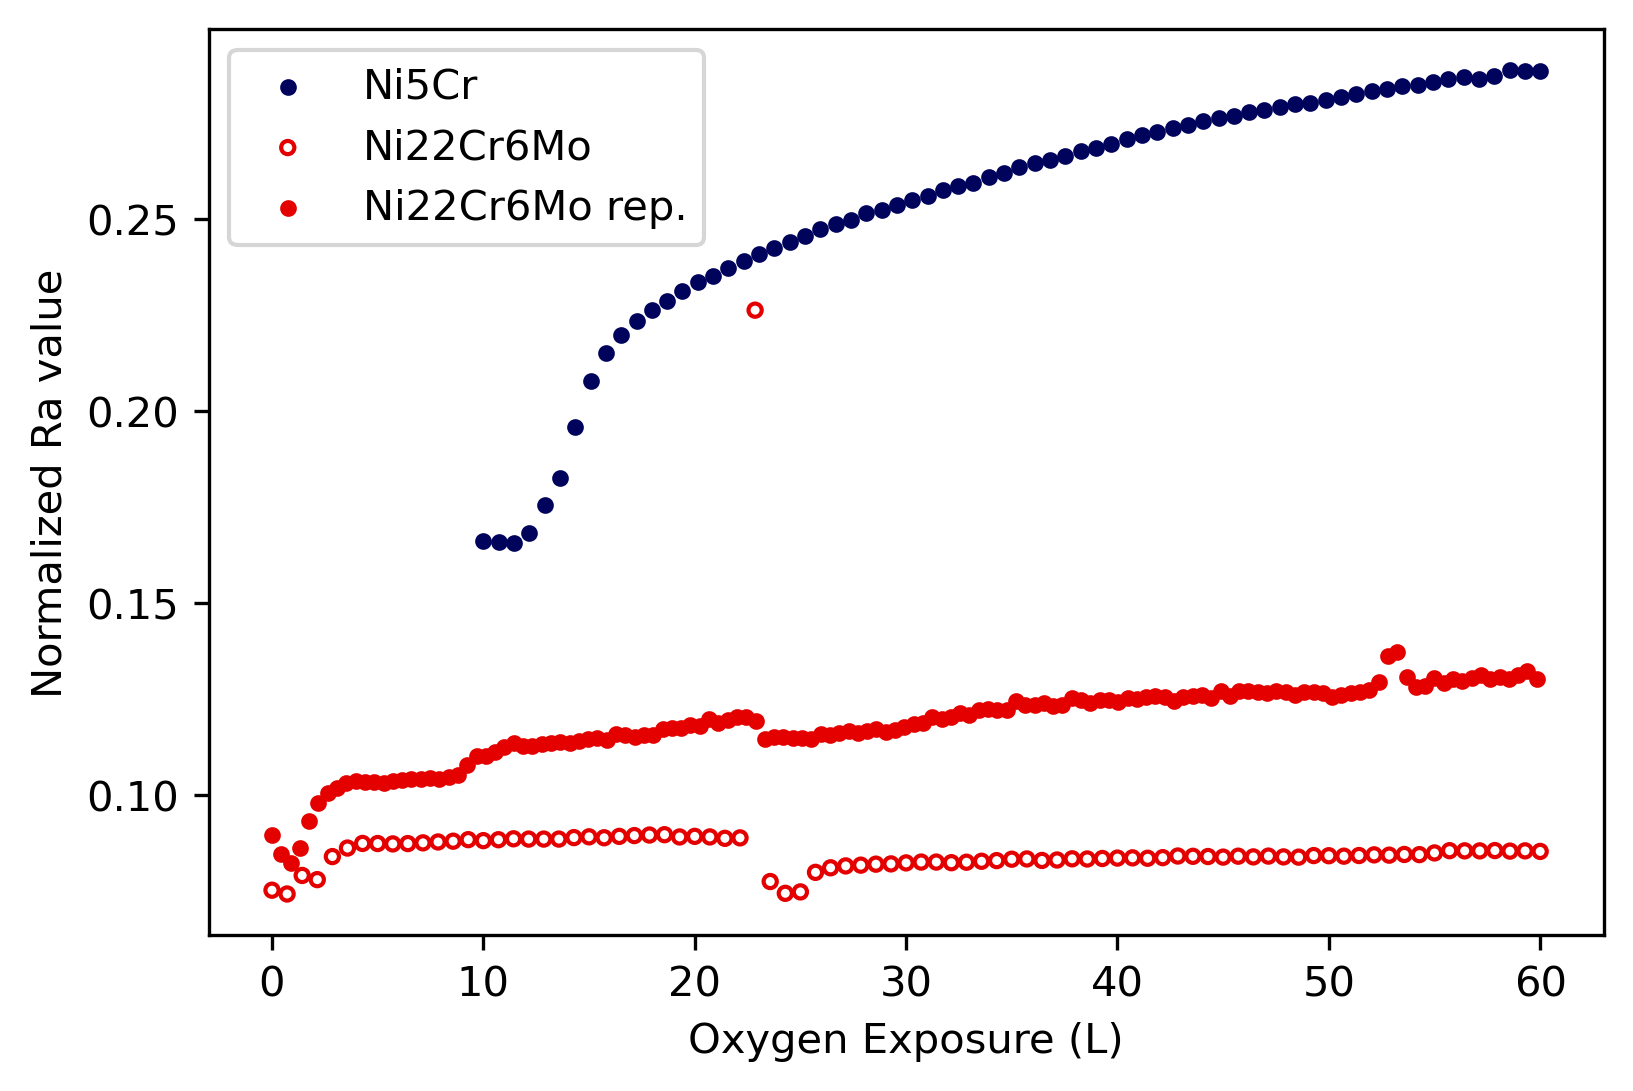

In [44]:
plt.scatter(ni5_langmuir_10_60, calc_ra(ni5_2, normalize=True),marker=".",c='xkcd:dark blue')
plt.scatter(mo_ox_langmuir, (leftgrain_Ra+rightgrain_Ra+centergrain_Ra)/3,s=10,marker = 'o',facecolor='none',edgecolor='xkcd:red')
plt.scatter(rep_ox_to_L, (rep_ra_left[12:149]+rep_ra_right[12:149])/2,marker= '.',c='xkcd:red')
# plt.scatter(leem_rep_range, leem_ox_ra,marker='.')

# plt.scatter(np.linspace(29,48,len(ni22cr_ox2_ra)),ni22cr_ox2_ra,marker='.')
# plt.scatter(np.linspace(48,65,len(ni22cr_ox3_ra)),ni22cr_ox3_ra,marker='.')
plt.ylabel("Normalized Ra value")
plt.xlabel("Oxygen Exposure (L)")
plt.legend(["Ni5Cr","Ni22Cr6Mo","Ni22Cr6Mo rep."])

In [22]:
# plt.scatter(ni5_langmuir_10_60, np.gradient(calc_ra(ni5_2, normalize=True)),marker=".",c='xkcd:dark blue')
# plt.scatter(mo_ox_langmuir, np.gradient((leftgrain_Ra+rightgrain_Ra+centergrain_Ra)/3),marker = '.',c='xkcd:red')
# plt.scatter(rep_ox_to_L, np.gradient((rep_ra_left[12:149]+rep_ra_right[12:149])/2), marker='.',c='xkcd:light red')
# # plt.scatter(leem_rep_range, leem_ox_ra,marker='.')

# # plt.scatter(np.linspace(29,48,len(ni22cr_ox2_ra)),ni22cr_ox2_ra,marker='.')
# # plt.scatter(np.linspace(48,65,len(ni22cr_ox3_ra)),ni22cr_ox3_ra,marker='.')
# plt.ylim([-0.02,0.02])
# plt.ylabel("Normalized Ra value")
# plt.xlabel("Oxygen Exposure (L)")
# plt.legend(["Ni5Cr","Ni22Cr6Mo","Ni22Cr6Mo rep."])

AxisError: axis 1 is out of bounds for array of dimension 1

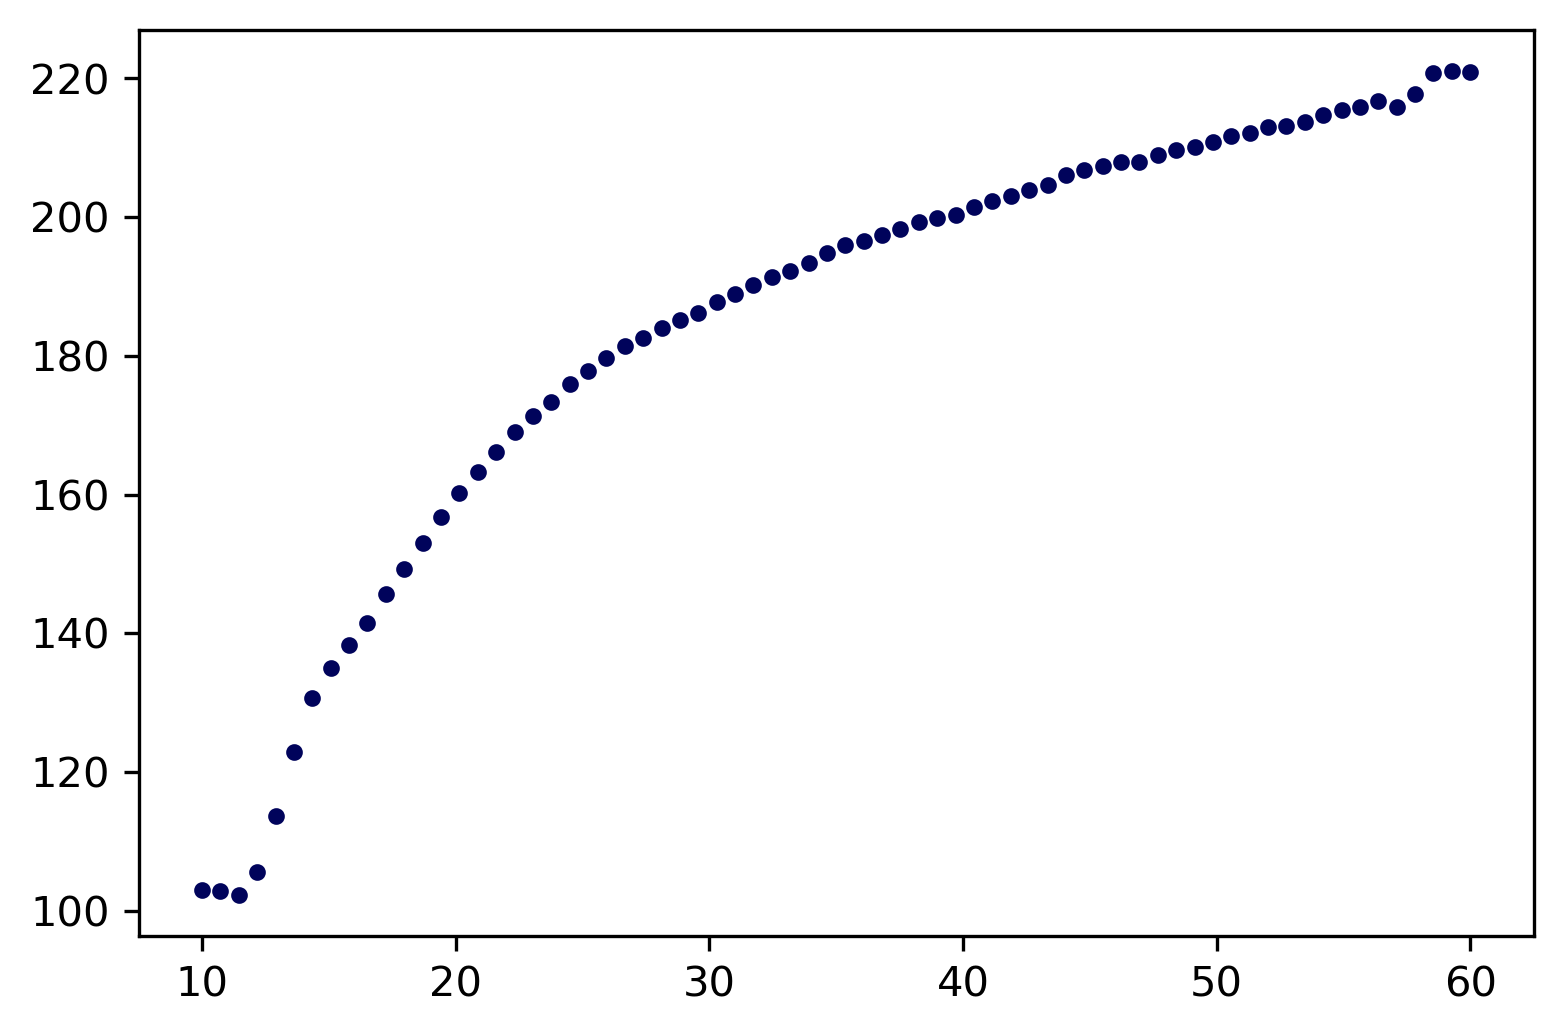

In [23]:
plt.scatter(ni5_langmuir_10_60, np.std(ni5_2, axis=(1,2)),marker=".",c='xkcd:dark blue')
plt.scatter(mo_ox_langmuir, np.std((leftgrain_Ra+rightgrain_Ra+centergrain_Ra)/3,axis=(1,2)),marker = '.',c='xkcd:red')
plt.scatter(rep_ox_to_L, np.std((rep_ra_left[12:149]+rep_ra_right[12:149])/2,axis=(1,2)), marker='.',c='xkcd:light red')
# plt.scatter(leem_rep_range, leem_ox_ra,marker='.')

# plt.scatter(np.linspace(29,48,len(ni22cr_ox2_ra)),ni22cr_ox2_ra,marker='.')
# plt.scatter(np.linspace(48,65,len(ni22cr_ox3_ra)),ni22cr_ox3_ra,marker='.')
plt.ylim([-0.02,0.02])
plt.ylabel("Normalized Ra value")
plt.xlabel("Oxygen Exposure (L)")
plt.legend(["Ni5Cr","Ni22Cr6Mo","Ni22Cr6Mo rep."])